In [2]:
#!pip install openai

In [105]:
# ChatGPT API Config
from configparser import ConfigParser

# Graph Viz
import matplotlib.pyplot as plt
import networkx as nx

from tqdm import tqdm
import datetime
import requests
import openai
import json
import os
import re


In [4]:
# Get API key stored in local cfg file
# How to is available here : https://towardsdatascience.com/keeping-credentials-safe-in-jupyter-notebooks-fbd215a8e311

parser = ConfigParser()
_ = parser.read('ObsidianGPT.cfg')
openai.api_key = parser.get('my_api', 'auth_key')

In [5]:
#Uncomment to show available OPENAI models
for i in openai.Model.list()["data"]:
    print(i["id"])

davinci
gpt-3.5-turbo-16k-0613
text-davinci-001
text-search-curie-query-001
babbage
text-babbage-001
gpt-3.5-turbo-16k
curie-instruct-beta
gpt-4-0314
gpt-4
davinci-similarity
code-davinci-edit-001
text-similarity-curie-001
ada-code-search-text
gpt-3.5-turbo-0613
text-search-ada-query-001
babbage-search-query
ada-similarity
text-curie-001
text-search-ada-doc-001
text-search-babbage-query-001
code-search-ada-code-001
curie-search-document
davinci-002
text-search-davinci-query-001
text-search-curie-doc-001
babbage-search-document
babbage-002
babbage-code-search-text
text-embedding-ada-002
davinci-instruct-beta
davinci-search-query
text-similarity-babbage-001
text-davinci-002
code-search-babbage-text-001
text-davinci-003
text-search-davinci-doc-001
code-search-ada-text-001
gpt-4-0613
ada-search-query
text-similarity-ada-001
ada-code-search-code
whisper-1
text-davinci-edit-001
davinci-search-document
curie-search-query
babbage-similarity
ada
ada-search-document
text-ada-001
text-similarity-

# Functions definition

In [6]:
# Passes a specific prompt to the chosen OpenAI GPT model
def generate_text(prompt, GPTmodel):
    response = openai.ChatCompletion.create(model=GPTmodel,messages=[{"role": "user", "content": prompt}])
    return response.choices[0].message.content.strip()

In [7]:
# Creates a local obsidian vault
def create_obsidian_vault(vault_name, parent_directory):
    '''Creates or Updates and Obsidian vault, in a given directory. Params are vault_name, parent_directory'''
    vault_path = os.path.join(parent_directory, vault_name)
    
    # Create the vault directory
    os.makedirs(vault_path, exist_ok=True)

    # Create default folders within the vault
    os.makedirs(os.path.join(vault_path, "attachments"), exist_ok=True)
    os.makedirs(os.path.join(vault_path, "notes"), exist_ok=True)
    
    return vault_path

In [8]:
# Extract strings with regexp
def regex_string_finder(input_string, pattern):
    '''
    Usage: regex_string_finder("This is a sample.text:with:colons", r'\.(.*?)\:')
    '''
    # Use re.search to find the first match of the pattern
    match = re.search(pattern, input_string)

    # Check if a match is found
    if match:
        # Extract the substring between '.' and ':'
        extracted_string = match.group(1)
        return extracted_string.strip()
    else:
        return "No match found."

In [9]:
def write_variable_to_text_file(variable, file_path):
    # Open the file in write mode ('w')
    with open(file_path, 'w') as file:
        # Write the variable's value to the file
        file.write(variable)
    
    print(f"Variable written to {file_path}")

In [ ]:
def visualize_json_as_graph(data_dict):
    # Create a directed graph
    G = nx.DiGraph()

    # Iterate through the JSON data and add nodes and edges to the graph
    for category, subcategories in data_dict.items():
        G.add_node(category, type="category")
        for subcategory, algorithms in subcategories.items():
            G.add_node(subcategory, type="subcategory")
            G.add_edge(category, subcategory)
            for algorithm in algorithms:
                G.add_node(algorithm, type="algorithm")
                G.add_edge(subcategory, algorithm)

    # Define node colors based on types
    node_colors = {
        "category": "lightblue",
        "subcategory": "lightgreen",
        "algorithm": "lightcoral",
    }
    for node in G.nodes():
        if "type" not in G.nodes[node]:
            G.nodes[node]["type"] = "default"

    colors = [node_colors[G.nodes[node]["type"]] for node in G.nodes()]

    # Create the graph visualization
    pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout
    nx.draw(G, pos, node_color=colors, with_labels=True, font_size=8)
    plt.title("JSON Data Visualization as a Graph")
    plt.show()

# Create and/or modify the local Obsidian Vault

In [10]:
today=datetime.datetime.now()
vault_path = create_obsidian_vault(vault_name=f"MyNewVault"+ "-" + str(today.date()), parent_directory=os.getcwd())
vault_path

'/Users/WDescamps/Desktop/code_projects/side_projects/ObsidianGPT/MyNewVault-2023-09-07'

## Prompt created by GPT, asking him to create a prompt to match my input of models

In [11]:
# Quite a bit of trial and error prompting led to the following prompt. Feel free to experiment with it!

In [37]:
# Get the list of models for different kinds of data from the GPT API
models_prompt = """
Provide an exhaustive list of popular machine learning and deep learning models for all types of data, 
grouped by data type and problem type.Provide as your response the dictionnary containing the results. 
"""

In [38]:
%%time
# Get the list of models, for each data type and problem type
models_text = generate_text(models_prompt, GPTmodel="gpt-4-0314") #Points to the latest GPT4 model or gpt-3.5-turbo for faster results vs lower query quality

CPU times: user 25.9 ms, sys: 11.7 ms, total: 37.6 ms
Wall time: 2min 2s


'{\n  "Structured Data": {\n    "Regression": [\n      "Linear Regression",\n      "Ridge Regression",\n      "Lasso Regression",\n      "Elastic Net",\n      "Support Vector Regression",\n      "Decision Tree Regression",\n      "Random Forest Regression",\n      "AdaBoost Regression",\n      "Gradient Boosting Regression",\n      "XGBoost",\n      "LightGBM",\n      "CatBoost",\n      "Artificial Neural Networks",\n      "Long Short-Term Memory"\n    ],\n    "Classification": [\n      "Logistic Regression",\n      "Linear Discriminant Analysis",\n      "Quadratic Discriminant Analysis",\n      "Support Vector Machines",\n      "Decision Tree Classifier",\n      "Random Forest Classifier",\n      "AdaBoost Classifier",\n      "Gradient Boosting Classifier",\n      "XGBoost Classifier",\n      "LightGBM Classifier",\n      "CatBoost Classifier",\n      "K-Nearest Neighbors",\n      "Naive Bayes Classifier",\n      "Artificial Neural Networks"\n    ],\n    "Clustering": [\n      "K-Mean

In [ ]:

#models_text

In [45]:
original_string = output
modified_string = re.sub(r'[ \n]', '', original_string)

# Convert the string to a Python dictionary
data_dict = json.loads(modified_string)

# Now you can work with the data_dict as a Python dictionary
print(data_dict)

{'StructuredData': {'Regression': ['LinearRegression', 'RidgeRegression', 'LassoRegression', 'ElasticNet', 'SupportVectorRegression', 'DecisionTreeRegression', 'RandomForestRegression', 'AdaBoostRegression', 'GradientBoostingRegression', 'XGBoost', 'LightGBM', 'CatBoost', 'ArtificialNeuralNetworks', 'LongShort-TermMemory'], 'Classification': ['LogisticRegression', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis', 'SupportVectorMachines', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'XGBoostClassifier', 'LightGBMClassifier', 'CatBoostClassifier', 'K-NearestNeighbors', 'NaiveBayesClassifier', 'ArtificialNeuralNetworks'], 'Clustering': ['K-MeansClustering', 'DBSCAN', 'HierarchicalClustering', 'SpectralClustering', 'MeanShift', 'AffinityPropagation', 'OPTICS', 'BIRCH'], 'DimensionalityReduction': ['PrincipalComponentAnalysis', 'LinearDiscriminantAnalysis', 't-DistributedStochasticNeighborEmbedding', 'FactorAnalysis', '

In [47]:
data_dict.keys()

dict_keys(['StructuredData', 'TimeSeriesData', 'TextData', 'ImageData', 'AudioData', 'GraphData'])

## Clean model list

In [48]:
#save models dict to disk with current date
with open(f'models_v1_3_{today.date()}.txt', 'w') as convert_file:
     convert_file.write(json.dumps(data_dict))

In [ ]:
# ChatGPT output is too variable, let's try again with our models extracted yesterday

In [52]:
data_dict

{'StructuredData': {'Regression': ['LinearRegression',
   'RidgeRegression',
   'LassoRegression',
   'ElasticNet',
   'SupportVectorRegression',
   'DecisionTreeRegression',
   'RandomForestRegression',
   'AdaBoostRegression',
   'GradientBoostingRegression',
   'XGBoost',
   'LightGBM',
   'CatBoost',
   'ArtificialNeuralNetworks',
   'LongShort-TermMemory'],
  'Classification': ['LogisticRegression',
   'LinearDiscriminantAnalysis',
   'QuadraticDiscriminantAnalysis',
   'SupportVectorMachines',
   'DecisionTreeClassifier',
   'RandomForestClassifier',
   'AdaBoostClassifier',
   'GradientBoostingClassifier',
   'XGBoostClassifier',
   'LightGBMClassifier',
   'CatBoostClassifier',
   'K-NearestNeighbors',
   'NaiveBayesClassifier',
   'ArtificialNeuralNetworks'],
  'Clustering': ['K-MeansClustering',
   'DBSCAN',
   'HierarchicalClustering',
   'SpectralClustering',
   'MeanShift',
   'AffinityPropagation',
   'OPTICS',
   'BIRCH'],
  'DimensionalityReduction': ['PrincipalComponen

## Add data to existing models

In [177]:
print(today.date())

2023-09-05


In [34]:
# A bit of history 
# On the 2023-05-05, the cell below cost 4$ in GPT4 API calls, and took 4 hours to execute
# On the 2023-09-05,ITS BROKEN. So the cell below cost 0.51$ in GPT4 API calls, and took 19 minutes to execute
# On the 2023-09-06, ITS BROKEN, does not create an entry for each model. It bunches them up in one entry under model type. The cell below cost 0.82$ in GPT4 API calls, and took 24 minutes to execute
# On the 2023-09-06, it works again! The cell below cost 3.5$ in GPT4 API calls, and took 1h24 minutes to execute


In [98]:
#Let's walk through the dictionnary structure
data_dict_light_details=data_dict.copy()
for data_type in tqdm(data_dict_light_details.keys()):
    # Get problem types for each data type (regression, classification...), and loop on them
    # print(data_type)
    for problem_type in data_dict_light_details[data_type].keys():
        #print(problem_type)
        for algorithm in data_dict_light_details[data_type][problem_type]:
            print(f"{data_type},{problem_type},{algorithm}")
            #break

100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3976.27it/s]

StructuredData,Regression,LinearRegression
StructuredData,Regression,RidgeRegression
StructuredData,Regression,LassoRegression
StructuredData,Regression,ElasticNet
StructuredData,Regression,SupportVectorRegression
StructuredData,Regression,DecisionTreeRegression
StructuredData,Regression,RandomForestRegression
StructuredData,Regression,AdaBoostRegression
StructuredData,Regression,GradientBoostingRegression
StructuredData,Regression,XGBoost
StructuredData,Regression,LightGBM
StructuredData,Regression,CatBoost
StructuredData,Regression,ArtificialNeuralNetworks
StructuredData,Regression,LongShort-TermMemory
StructuredData,Classification,LogisticRegression
StructuredData,Classification,LinearDiscriminantAnalysis
StructuredData,Classification,QuadraticDiscriminantAnalysis
StructuredData,Classification,SupportVectorMachines
StructuredData,Classification,DecisionTreeClassifier
StructuredData,Classification,RandomForestClassifier
StructuredData,Classification,AdaBoostClassifier
StructuredData,

In [ ]:
#First, let's visualize our results 

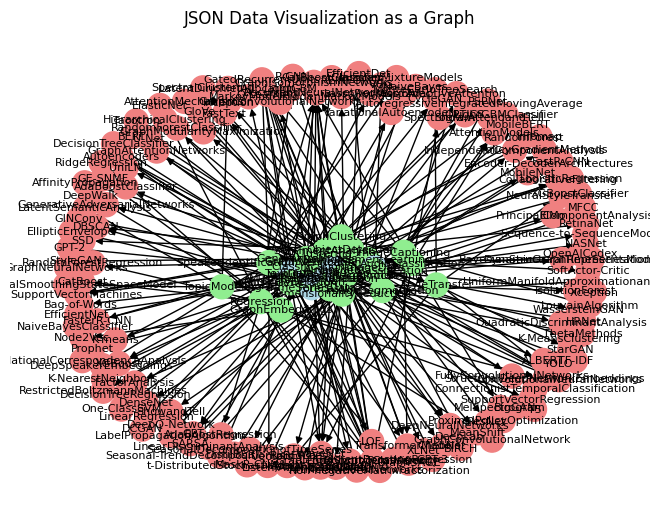

In [104]:
visualize_json_as_graph(data_dict)

Not the most fun viz, let's try an interactive one in a separate Notebook using Dash

##### Idée : Créer la vault, filer un template markdown et populer la vault avec directement les templates .md remplis par chatGPT
Permettrait de passer outre le truc ligne par ligne dégeulasse

#### Isoler deja une partie du dictionnaire pour tester dessus si ca marche

In [121]:
data_dict.keys()

dict_keys(['StructuredData', 'TimeSeriesData', 'TextData', 'ImageData', 'AudioData', 'GraphData'])

In [120]:
#Choisissons "StructuredData"
data_dict["StructuredData"]

{'Regression': ['LinearRegression',
  'RidgeRegression',
  'LassoRegression',
  'ElasticNet',
  'SupportVectorRegression',
  'DecisionTreeRegression',
  'RandomForestRegression',
  'AdaBoostRegression',
  'GradientBoostingRegression',
  'XGBoost',
  'LightGBM',
  'CatBoost',
  'ArtificialNeuralNetworks',
  'LongShort-TermMemory'],
 'Classification': ['LogisticRegression',
  'LinearDiscriminantAnalysis',
  'QuadraticDiscriminantAnalysis',
  'SupportVectorMachines',
  'DecisionTreeClassifier',
  'RandomForestClassifier',
  'AdaBoostClassifier',
  'GradientBoostingClassifier',
  'XGBoostClassifier',
  'LightGBMClassifier',
  'CatBoostClassifier',
  'K-NearestNeighbors',
  'NaiveBayesClassifier',
  'ArtificialNeuralNetworks'],
 'Clustering': ['K-MeansClustering',
  'DBSCAN',
  'HierarchicalClustering',
  'SpectralClustering',
  'MeanShift',
  'AffinityPropagation',
  'OPTICS',
  'BIRCH'],
 'DimensionalityReduction': ['PrincipalComponentAnalysis',
  'LinearDiscriminantAnalysis',
  't-Distri

In [ ]:
### Light test to enrich our dict:

%%time
data_dict_light_details=data_dict.copy()
for model in tqdm(data_dict_light_details):
    resource_prompt = f"""
    For the {model['name']} model with {model['data_type']} , provide:
    1. A short description of the model.
    2. A list of the pros and cons of the model.
    3. The three most relevant use cases.
    4. Three great resources with relevant internet links for implementing the model.
    5. The top 5 people with the most expertise relative to this model, with a link to their github or linkedin page
    """
    resources = generate_text(resource_prompt, GPTmodel="gpt-4-0314")
    # If debugging, uncomment line below
    print(resources)

In [20]:
%%time
models_with_details=full_model_list.copy()
for model in tqdm(models_with_details):
    resource_prompt = f"""
    For the {model['name']} model with {model['data_type']} , provide:
    1. A short description of the model.
    2. A list of the pros and cons of the model.
    3. The three most relevant use cases.
    4. Three great resources with relevant internet links for implementing the model.
    5. The top 5 people with the most expertise relative to this model, with a link to their github or linkedin page
    """
    resources = generate_text(resource_prompt, GPTmodel="gpt-4-0314")
    # If debugging, uncomment line below
    print(resources)
    
    # Specify the file path where you want to create the text file
    file_path = f"{model['name']}_{model['data_type']}.txt"
    
    # Call the function to write the variable to the file
    write_variable_to_text_file(resources, file_path)

  1%|▊                                                        | 1/74 [00:55<1:07:40, 55.63s/it]

1. Description:
Linear regression is a fundamental type of predictive analysis which is used to understand the relationship between two or more variables. The variable we want to predict is called the dependent variable (or sometimes, the outcome, target). The variables we use to predict the value of the dependent variable are called the independent variables (or sometimes, the predictors, inputs, regressors).

2. Pros and Cons:
   Pros:
   - Simple to understand and interpret.
   - Little to no tuning required.
   - Fast to model and predict.
   - Works best with numerical continuous data.
   
   Cons:
   - It assumes linear relationship between independent and dependent variables.
   - It can be adversely affected by outliers.
   - Linear regression may over-simplify real-world problems by assuming a linear relationship among the variables.

3. Use Cases:
   - Predicting sales amount given advertising budgets in different venues (TV, Radio, Newspapers).
   - Predicting house prices g

  3%|█▌                                                       | 2/74 [01:54<1:09:09, 57.63s/it]

1. Description:
The Polynomial Regression model is a type of regression analysis in which the relationship between the independent variable x and the dependent variable y is modeled as an nth degree polynomial. It expands the linear model by adding extra predictors, obtained by raising each of the original predictors to a power. Polynomial regression fits a nonlinear relationship between the value of x and the corresponding conditional mean of y, denoted E(y |x).

2. Pros and Cons:

Pros:
- Polynomial regression models can fit a wider range of data than linear regression, as they can model relationships that change in direction.
- With high-degree polynomials, you can fit nearly any shape dataset.
- They're great for modeling curves and other complex data shapes.

Cons:
- Polynomial regression models can overfit data easily, leading to high-variance models that do not generalize well to future data.
- The addition of too many polynomial terms can greatly enlarge the amount of collinear

  3%|█▌                                                       | 2/74 [02:24<1:26:50, 72.37s/it]


KeyboardInterrupt: 

In [ ]:
# Maintenant qu'on a écrit les fichiers sur le disque on peut en extraire plus proprement les infos

## Save and/or reload the detailed models dictionnary

In [205]:
# first, let's save our dictionnary of enriched models to disk with the current date attached
with open(f'models_with_details_{datetime.datetime.now().date()}.txt', 'w') as convert_file:
     convert_file.write(json.dumps(models_with_details))

In [146]:
# Load file from disk if necessary
filename = f'models_with_details_{datetime.datetime.now().date()}.txt'
with open(filename, 'r') as read_file:
    models_with_details = json.load(read_file)

## Parsing the detailed models 

## Write to Obsidian Vault

In [200]:
# Iterate through the models list
for model in models_with_details:
    model_filename = f"{model['name']}.md"
    model_filepath = os.path.join(vault_path, model_filename)
    data_type = model['data_type']
    model_name = model['name']

    # Create the directory for the data type if it does not exist
    data_type_path = os.path.join(vault_path, data_type)
    if not os.path.exists(data_type_path):
        os.makedirs(data_type_path)

    # Create a file for the model and write its information
    file_name = f"{model_name}.md"
    file_path = os.path.join(data_type_path, file_name)
    with open(file_path, "w") as f:
        
        f.write(f"**Model Type:** {model['model_type']}\n")
        f.write(f"**Data Type:** {model['data_type']}\n\n")
        
        # Add additional information about the model if available
        if 'use_cases' in model:
            f.write("## Use Cases :\n\n")
            for use_case in model['use_cases']:
                f.write(use_case +"\n\n")
            f.write("\n")
        
        #f.write(f"**Description**:\n\n{model['description']}\n\n") # Description field is not correct, commented for now
        
        f.write(f"## Python code: \n{model['python_code']}\n\n")
        
        # Add additional information about the model if available
        if 'resources' in model:
            f.write("## Resources\n\n")
            for resource in model['resources']:
                f.write(resource +"\n")
            f.write("\n")

        # Add "See Also" section with links to related models
        f.write(f"**See Also**:\n\n")
        for other_model in models:
            if other_model['name'] != model['name'] and other_model['data_type'] == model['data_type']:
                f.write(f"- [[{other_model['name']}]]\n")


        # Add relevant tags with hierarchy. Strip special chars for clarity
        f.write(f"\n---\n")
        root_tag = model['data_type'].replace(' ', '').lower()
        leaf_tag = model['name'].replace('(', '').replace(')', '').replace(' ', '').lower()
        f.write(f"tags: #{root_tag}, #{root_tag}/{leaf_tag}\n")
